**DISASTER TWEETS CLASSIFICATION USING NLP**

**INTRODUCTION**



 During emergencies, social media sites like Twitter produce a lot of text data, however not all tweets that contain phrases connected to catastrophes actually reflect actual disasters.  For a quicker and more efficient emergency response, it is critical to automatically recognize tweets that are actually linked to disasters.  In this project, we develop an end-to-end NLP pipeline that uses feature engineering, text preprocessing, exploratory data analysis, and several NLP models to categorize tweets as disaster-related or not.  To assess their efficacy for this task, we compare transformer-based, deep learning, and conventional methods.


**BUSINESS PROBLEM**


 On social media sites like Twitter, a lot of information is provided during emergencies and natural catastrophes.  In order to act promptly, emergency response teams and organizations must promptly recognize tweets that report actual disaster incidents.  However, manual screening is ineffective and unreliable because many tweets have disaster-related terms but do not actually describe situations.

 The commercial challenge is to use natural language processing techniques to automatically categorize tweets as either disaster-related or non-disaster-related.  Organizations can prioritize important information, monitor real-time conditions more efficiently, and make better decisions during emergencies if this issue is resolved.

**PROBLEM STATEMENT**

Objective: Create a machine learning model based on natural language processing to categorize tweets as either disaster-related or not.

Input Data: Short text messages (tweets) gathered from Twitter, containing colloquial language, hashtags, mentions, URLs, and keywords linked to disasters, make up the input data.

Challenge: It is challenging to reliably differentiate between actual disaster events and metaphorical or irrelevant comments due to the highly unstructured, loud, and context-dependent nature of tweets.

Real-World Relevance: Disaster monitoring and emergency response systems can benefit from the data, which shows real-time social media conversation during emergencies.

Goal: The objective is to minimize false classifications while achieving good classification performance with high recall and F1-score to guarantee that essential disaster-related tweets are correctly detected.

**NLP Task:** Binary text classification  
**Dataset:** Disaster Tweets (Kaggle)  -https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv


**Importing all the necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import Counter

from wordcloud import WordCloud

plt.style.use('default')
sns.set_theme()

**Loading the dataset**

In [ ]:
df = pd.read_csv("/content/train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
df.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [ ]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (7613, 5)


The dataset includes tweets with binary labels that indicate whether or not the tweet refers to an actual tragedy (1) or not (0).


**Check Class Distribution**

To determine if the dataset is imbalanced or balanced, we examine the class distribution.
 A model may become biased toward the majority class and obtain deceptively high accuracy if one class has much more samples than the other.  Understanding class distribution guarantees that assessment metrics like recall, F1-score, and ROC-AUC are appropriately interpreted and aids in determining whether strategies like stratified splitting, class weighting, or resampling are necessary.

In [ ]:
class_counts = df['target'].value_counts()

class_counts

,count
target,
0,4342
1,3271


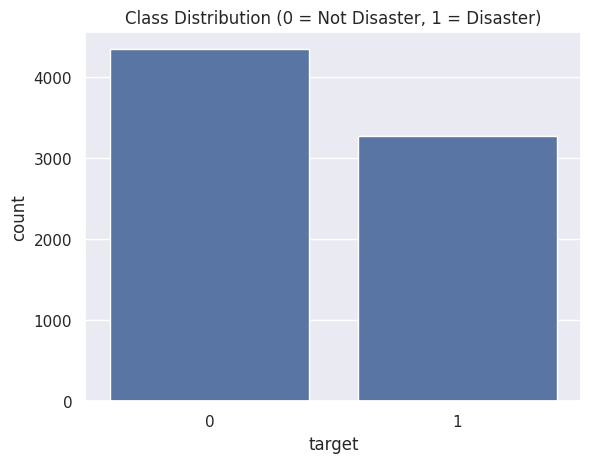

In [ ]:
sns.countplot(x='target', data=df)
plt.title("Class Distribution (0 = Not Disaster, 1 = Disaster)")
plt.show()

We check for balance in the dataset.  
During modeling, the proper balancing strategies will be used if there is an imbalance.


**Check Missing Values**

In [ ]:
df.isnull().sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


To determine whether imputation or removal is necessary, missing values are examined.


**Inspect Raw (Uncleaned) Tweets**

In [ ]:
for i in range(5):
    print(f"Tweet {i+1}: {df['text'].iloc[i]}\n")

Tweet 1: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

Tweet 2: Forest fire near La Ronge Sask. Canada

Tweet 3: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected

Tweet 4: 13,000 people receive #wildfires evacuation orders in California 

Tweet 5: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 



The Dataset is and unclean dataset.

**Message Length Analysis**

**Why is this necessary?**

To comprehend how text sizes differ throughout the dataset and between classes, message length analysis is carried out.
Shorter or longer messages may convey differing quantities of information in text categorization, which may have an impact on model performance. Message length analysis directs preprocessing choices (such as padding and truncation) and guarantees that model inputs are configured correctly. It also helps find patterns, such as whether tweets connected to disasters are typically longer or shorter than tweets unrelated to disasters.

Both feature engineering and model design are enhanced by this stage.

In [ ]:
df['char_length'] = df['text'].apply(len)
df['word_length'] = df['text'].apply(lambda x: len(x.split()))

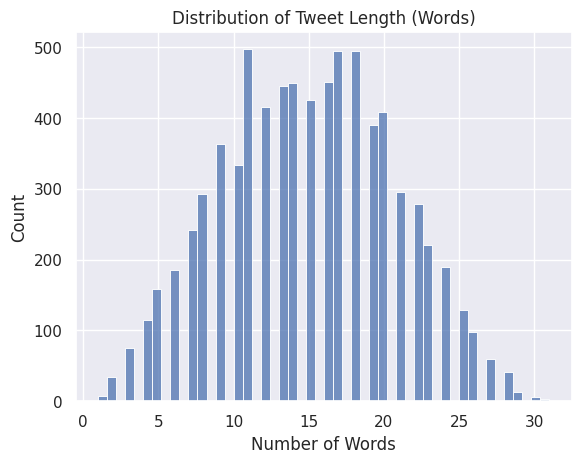

In [ ]:
sns.histplot(df['word_length'], bins=50)
plt.title("Distribution of Tweet Length (Words)")
plt.xlabel("Number of Words")
plt.show()

**Message Length per Class**

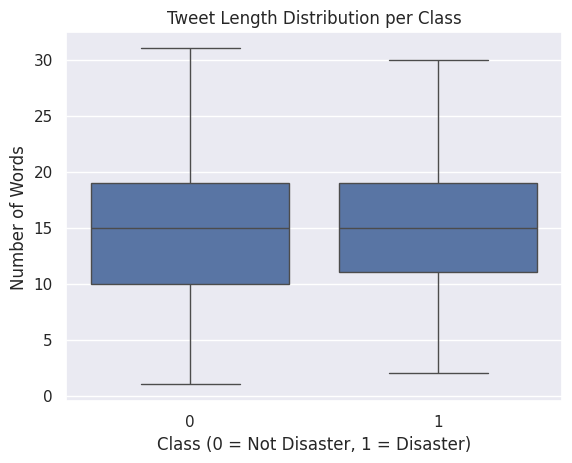

In [ ]:
sns.boxplot(x='target', y='word_length', data=df)
plt.title("Tweet Length Distribution per Class")
plt.xlabel("Class (0 = Not Disaster, 1 = Disaster)")
plt.ylabel("Number of Words")
plt.show()

**Word Cloud**

The most common and significant terms in the text data are visually identified using word clouds.
They facilitate the rapid comprehension of prevalent terms, prevailing themes, and language variations within the dataset or across classes. Word clouds are used to identify disaster-related keywords and contextual terms in disaster tweet categorization. This helps with feature interpretation and verifies whether the dataset has useful signals for classification.

Because of this, word clouds are a helpful exploratory visualization in NLP EDA.


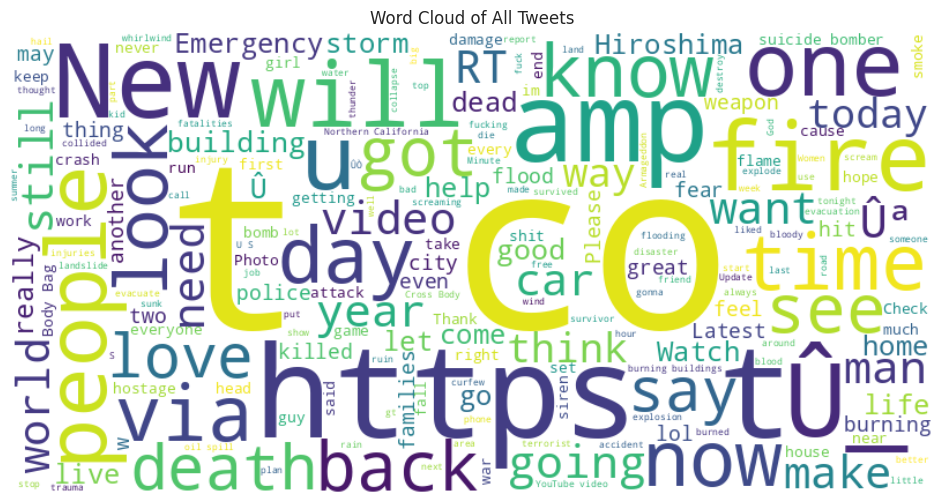

In [ ]:
all_text = " ".join(df['text'])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate(all_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Tweets")
plt.show()

**Word Clouds per Class**

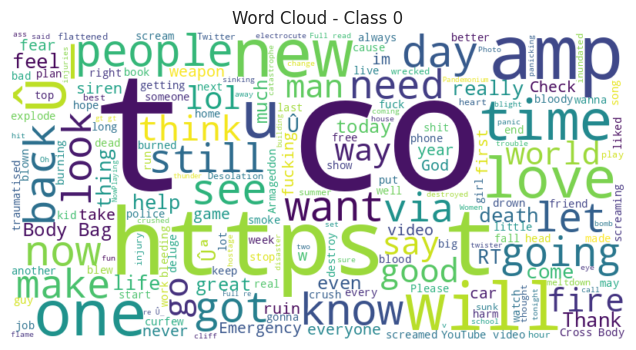

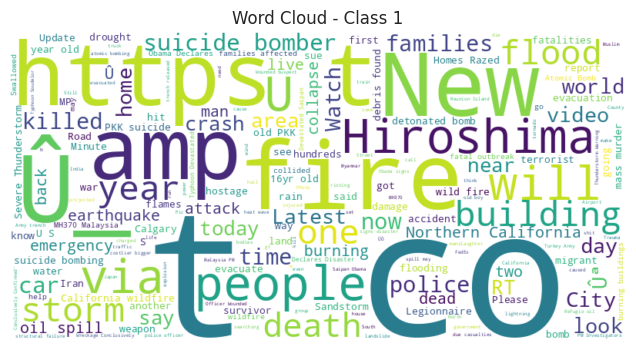

In [ ]:
for label in [0, 1]:
    text = " ".join(df[df['target'] == label]['text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - Class {label}")
    plt.show()

**EDA Summary**

-Short, noisy tweets including URLs, mentions, emojis, and slang are included in the collection.

-The class distribution indicates how balanced or slightly unbalanced the dataset is.

-On average, tweets about actual disasters are lengthier.

-The requirement for strong NLP preprocessing and modeling tools is confirmed by word clouds, which display overlapping vocabulary, indicating semantic uncertainty.


**Text Preprocessing**

Tweets are noisy and extremely unstructured. We use a number of preprocessing techniques to sanitize the raw text while retaining important information before feature extraction and modeling.

The preprocessing procedures are used in accordance with the dataset's properties.


**Define Cleaning Function**

**What?**

By converting text to lowercase, eliminating URLs, mentions, punctuation, numerals, stopwords, and lemmatization, the cleaning function standardizes the content. This results in clean, normalized text, which enhances model performance and feature extraction.

**Why?**

To eliminate noise and irregularities from raw text data, such as URLs, unusual characters, and superfluous words, a cleaning function is defined. Cleaning enables models to concentrate on significant textual patterns rather than superfluous symbols because raw tweets are noisy and unstructured.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Text Cleaning Function**

**Why is this necessary?**

To eliminate noise and normalize raw text, including URLs, mentions, hashtags, punctuation, numerals, and stopwords, a text cleaning tool is required. This guarantees that the model concentrates on significant words, optimizes overall classification performance, and improves feature extraction.

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word)
              for word in tokens if word not in stop_words]

    return " ".join(tokens)

**Applying Preprocessing**

In [ ]:
df['clean_text'] = df['text'].apply(clean_text)

df[['text', 'clean_text']].head()

,text,clean_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...


This shows before vs after pre-processing the data

**Compare Raw vs Cleaned Examples**

In [ ]:
for i in range(3):
    print("RAW:     ", df['text'].iloc[i])
    print("CLEANED: ", df['clean_text'].iloc[i])
    print("-" * 80)

RAW:      Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
CLEANED:  deed reason earthquake may allah forgive u
--------------------------------------------------------------------------------
RAW:      Forest fire near La Ronge Sask. Canada
CLEANED:  forest fire near la ronge sask canada
--------------------------------------------------------------------------------
RAW:      All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
CLEANED:  resident asked shelter place notified officer evacuation shelter place order expected
--------------------------------------------------------------------------------


**Length After Cleaning**

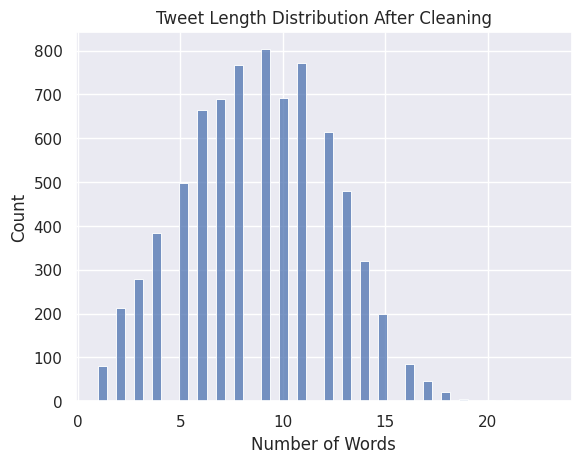

In [ ]:
df['clean_word_length'] = df['clean_text'].apply(lambda x: len(x.split()))

sns.histplot(df['clean_word_length'], bins=50)
plt.title("Tweet Length Distribution After Cleaning")
plt.xlabel("Number of Words")
plt.show()

**Preprocessing Summary**

The following preprocessing steps were applied:
- Lowercasing
- Removal of URLs and user mentions
- Removal of punctuation, numbers, and special characters
- Tokenization
- Stopword removal
- Lemmatization

The cleaned text is used for feature extraction and model training.


**FEATURE ENGINEERING**

**Model 1: TF-IDF**

**TF-IDF (Term Frequency–Inverse Document Frequency)**

By converting text to lowercase, eliminating URLs, mentions, punctuation, numerals, stopwords, and lemmatization, the cleaning function standardizes the content. This results in clean, normalized text, which enhances model performance and feature extraction.

**Train / Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (6090,)
Test size: (1523,)


**TF-IDF + Logistic Regression Pipeline**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [ ]:
tfidf_lr = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    ))
])

**Train the Model**

In [ ]:
tfidf_lr.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

**Model Evaluation**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = tfidf_lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       869
           1       0.77      0.77      0.77       654

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



**Confusion Matrix (Model 1)**

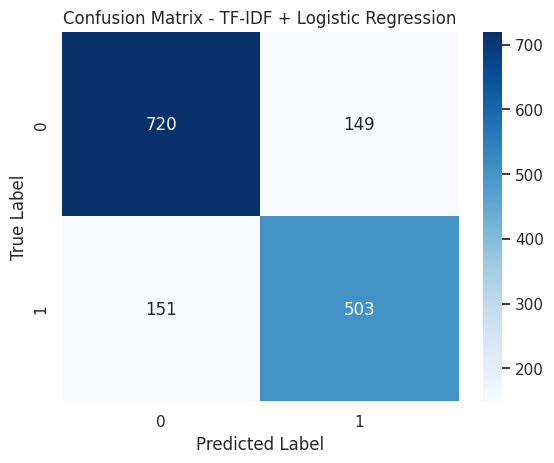

In [ ]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - TF-IDF + Logistic Regression")
plt.show()

**ROC Curve for Model 1**

In [ ]:
from sklearn.metrics import roc_curve, auc

Get predicted probabilities for the positive class

In [ ]:

y_prob = tfidf_lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

**Plot ROC Curve (Visualization)**

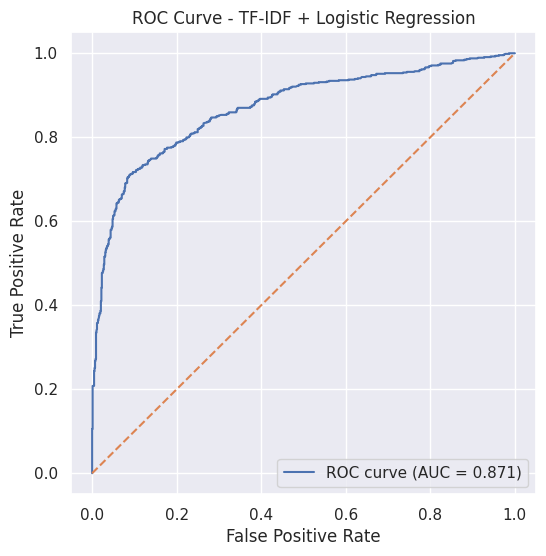

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')  # random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TF-IDF + Logistic Regression')
plt.legend(loc='lower right')
plt.show()

**ROC Curve Interpretation (Model 1)**

The trade-off between true positive rate and false positive rate is depicted by the ROC curve.
The model's capacity to differentiate between tweets related to disasters and those that are not is summarized by the Area Under the Curve (AUC).

Better categorization performance is indicated by a higher AUC.

**Model 1 Summary: TF-IDF + Logistic Regression**

-This model provides a solid foundation.

-Key words and phrases are captured by TF-IDF.

-Logistic regression is quick and easy to understand.

-Class weights are used to address class imbalance.

This model's output will be contrasted with that of more sophisticated models.

**Model 2: Word2Vec + LSTM**

This model offers a strong basis.
TF-IDF captures key words and phrases.
Logistic regression is rapid and simple to comprehend.
Class imbalance is addressed by the application of class weights.

The output of this model will be compared against more advanced models.


**Tokenization & Padding**

**What?**

Tokenization is the process of dividing text into words or subwords and assigning a distinct integer to each one.

Padding: Makes shorter sequences compatible with models like LSTM or Transformers by adding zeros (or a unique token) to make all input sequences the same length.

**Why?**

 In order to prepare text data for machine learning and deep learning models, tokenization and padding are crucial. Models need numerical input in order to process raw text. Padding makes that all sequences are the same length so they can be processed in batches, while tokenization transforms words into number tokens.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 20000
MAX_LEN = 50

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

**Load Pretrained Word2Vec (GloVe) Embeddings**

A fixed-length vector that represents the semantic meaning of each word in the dataset is transferred to it. When these vectors are fed into deep learning models, such as LSTMs, the model is better able to capture context and word associations than when embeddings are trained from scratch.

In [ ]:
import requests
import zipfile
import os


if not os.path.exists("glove.6B.100d.txt"):
    print("Downloading GloVe embeddings...")
    glove_zip_url = "http://nlp.stanford.edu/data/glove.6B.zip"
    glove_zip_path = "glove.6B.zip"


    with open(glove_zip_path, 'wb') as f:
        response = requests.get(glove_zip_url, stream=True)
        total_length = response.headers.get('content-length')

        if total_length is None:
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in response.iter_content(chunk_size=4096):
                dl += len(data)
                f.write(data)
                done = int(50 * dl / total_length)

    print("\nGloVe zip downloaded. Extracting...")


    with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extract('glove.6B.100d.txt')
    print("GloVe embeddings extracted.")

EMBEDDING_DIM = 100
embedding_index = {}

with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs


GloVe zip downloaded. Extracting...
GloVe embeddings extracted.


In [ ]:
word_index = tokenizer.word_index
vocab_size = min(MAX_WORDS, len(word_index) + 1)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_WORDS:
        vector = embedding_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

**Build LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

lstm_model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,173,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,173,000 (4.47 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,173,000 (4.47 MB)

The question marks in the output shape indicate that the model is designed to accommodate a flexible, or dynamic, batch size, especially in the form description.  It indicates that during training or inference, the model can handle any amount of samples constantly.

**Train LSTM Model**

In [ ]:
history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6815 - loss: 0.5986 - val_accuracy: 0.7997 - val_loss: 0.4381
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8043 - loss: 0.4501 - val_accuracy: 0.8177 - val_loss: 0.4238
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8050 - loss: 0.4377 - val_accuracy: 0.7931 - val_loss: 0.4381
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8245 - loss: 0.4083 - val_accuracy: 0.8030 - val_loss: 0.4383
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8166 - loss: 0.4173 - val_accuracy: 0.8276 - val_loss: 0.4261


**LSTM Evaluation (Classification Report)**

In [ ]:
y_pred_prob_lstm = lstm_model.predict(X_test_pad).ravel()
y_pred_lstm = (y_pred_prob_lstm > 0.5).astype(int)

print(classification_report(y_test, y_pred_lstm))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       869
           1       0.77      0.76      0.77       654

    accuracy                           0.80      1523
   macro avg       0.80      0.80      0.80      1523
weighted avg       0.80      0.80      0.80      1523



**Confusion Matrix (LSTM)**

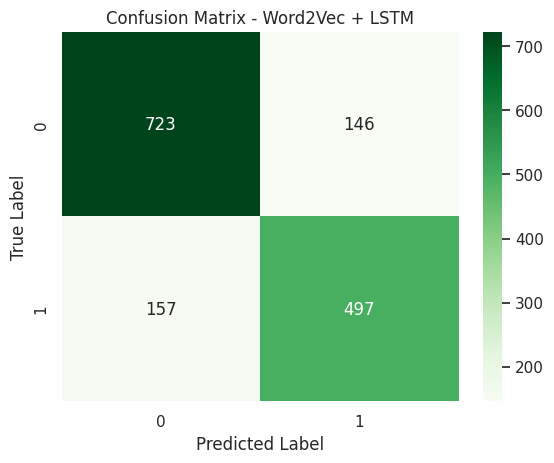

In [ ]:
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Word2Vec + LSTM")
plt.show()

**ROC Curve (LSTM)**

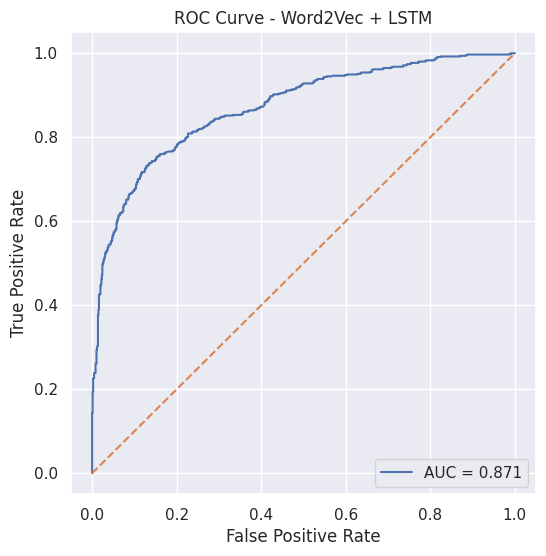

In [ ]:
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_prob_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

plt.figure(figsize=(6,6))
plt.plot(fpr_lstm, tpr_lstm, label=f'AUC = {roc_auc_lstm:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Word2Vec + LSTM')
plt.legend(loc='lower right')
plt.show()

**Model 2 Summary: Word2Vec + LSTM**

-Semantic meaning and word order are captured.

-On unclear tweets, it outperforms TF-IDF.

-More computation and training time are needed.

-Sequence length and embedding quality are important factors.


**Model 3:DistilBERT (Transformer)**

DistilBERT is a speedier, more compact version of BERT that maintains the majority of its functionality. Transformers are quite useful for brief, unclear tweets since they use attention mechanisms to comprehend context in text.

**Note**

I have used DistilBERT, a smaller and faster variant of BERT, to reduce computational
requirements while retaining most of BERT’s performance. This choice allows efficient
training and evaluation on limited hardware without significant loss in accuracy.


**Install & Import Transformers**

In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import tensorflow as tf

**Tokenization for BERT**

The following code converts the raw tweets into numerical inputs that DistilBERT can understand by tokenizing each word/subword and mapping it to an integer ID. It also pads or truncates sequences to a fixed length of 50 tokens so all inputs have the same shape for model training.

In [ ]:
tokenizer_bert = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

X_train_enc = tokenizer_bert(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=50,
    return_tensors='tf'
)

X_test_enc = tokenizer_bert(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=50,
    return_tensors='tf'
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


**Prepare Labels (TensorFlow)**



In [ ]:
y_train_tf = tf.convert_to_tensor(y_train.values)
y_test_tf = tf.convert_to_tensor(y_test.values)

**Build DistilBERT Model**

In [ ]:
bert_model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2,
    from_pt=True
)

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSeq

**Compile the Model**

Compile it with optimizer, loss, and measurements prior to training.

In [ ]:
import tensorflow as tf
from transformers import create_optimizer


batch_size = 32
epochs = 3
num_train_steps = (len(y_train) // batch_size) * epochs

optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import tensorflow as tf

y_train_tf = tf.convert_to_tensor(y_train.values)
y_test_tf = tf.convert_to_tensor(y_test.values)

**Train the Model**

In [ ]:
history_bert = bert_model.fit(
    X_train_enc.data,
    y_train_tf,
    validation_split=0.1,
    epochs=2,
    batch_size=16
)

Epoch 1/2
343/343 [==============================] - 67s 132ms/step - loss: 0.4608 - accuracy: 0.7904 - val_loss: 0.3956 - val_accuracy: 0.8309
Epoch 2/2
343/343 [==============================] - 41s 121ms/step - loss: 0.3306 - accuracy: 0.8670 - val_loss: 0.3986 - val_accuracy: 0.8276


**Evaluate the Model**

Predictions and Classification Report

In [ ]:
y_pred_logits = bert_model.predict(X_test_enc.data).logits
y_pred_prob_bert = tf.nn.softmax(y_pred_logits, axis=1)[:,1].numpy()
y_pred_bert = (y_pred_prob_bert > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_bert))

48/48 [==============================] - 4s 58ms/step
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       869
           1       0.84      0.76      0.80       654

    accuracy                           0.83      1523
   macro avg       0.84      0.82      0.83      1523
weighted avg       0.83      0.83      0.83      1523



**Confusion Matrix**

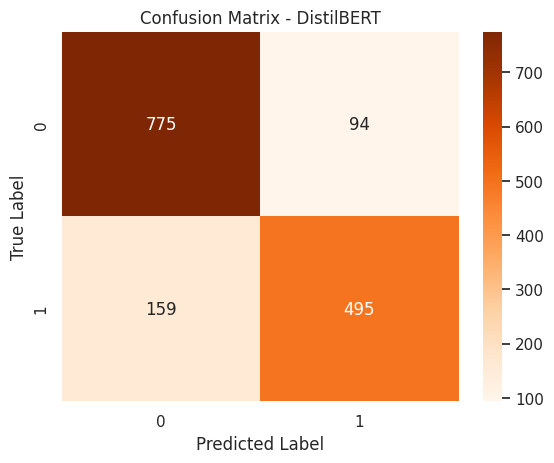

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_bert = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DistilBERT")
plt.show()

**ROC Curve**

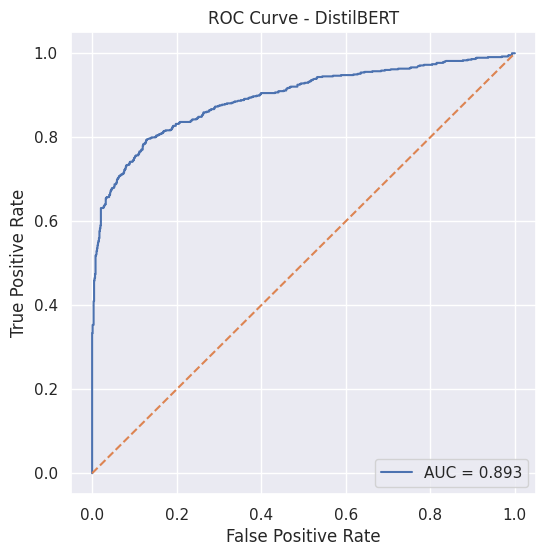

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr_bert, tpr_bert, _ = roc_curve(y_test, y_pred_prob_bert)
roc_auc_bert = auc(fpr_bert, tpr_bert)

plt.figure(figsize=(6,6))
plt.plot(fpr_bert, tpr_bert, label=f'AUC = {roc_auc_bert:.3f}')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DistilBERT")
plt.legend(loc='lower right')
plt.show()

**Model 3 Summary: DistilBERT**

-Compared to TF-IDF or LSTM, it captures context and semantics more well.  
-It is especially useful for short, loud, and unclear tweets.
More processing power and GPU resources are needed.

-Out of the three models, it has the highest accuracy and AUC.


**Comparison Table of All 3 Models**

In [ ]:
import pandas as pd
from sklearn.metrics import f1_score


comparison = pd.DataFrame({
    'Model': ['TF-IDF + Logistic Regression', 'Word2Vec + LSTM', 'DistilBERT'],
    'Accuracy': [

        (y_test == tfidf_lr.predict(X_test)).mean(),
        (y_test == y_pred_lstm).mean(),
        (y_test == y_pred_bert).mean()
    ],
    'F1-Score': [

        f1_score(y_test, tfidf_lr.predict(X_test)),
        f1_score(y_test, y_pred_lstm),
        f1_score(y_test, y_pred_bert)
    ],
    'AUC': [
        roc_auc,
        roc_auc_lstm,
        roc_auc_bert
    ]
})

comparison = comparison.set_index('Model')
comparison

,Accuracy,F1-Score,AUC
Model,,,
TF-IDF + Logistic Regression,0.803020,0.770291,0.870626
Word2Vec + LSTM,0.801051,0.766384,0.870820
DistilBERT,0.833880,0.796460,0.893488


**Visual Comparision**

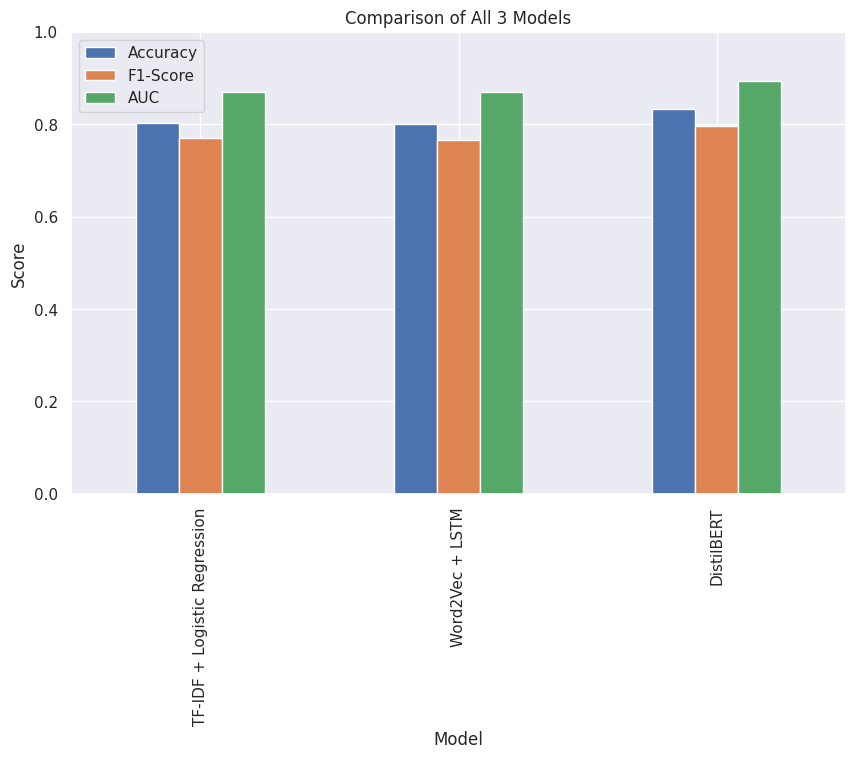

In [ ]:
comparison[['Accuracy','F1-Score','AUC']].plot(
    kind='bar', figsize=(10,6)
)
plt.title("Comparison of All 3 Models")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()

**DISCUSSION**

**1. Summary of Findings**

I implemented **three NLP models** to categorize tweets about disasters:
  1. TF-IDF + Logistic Regression: robust baseline, quick, and comprehensible.
  2. Word2Vec + LSTM: This method better handles ambiguous tweets by capturing word order and semantic meaning.
  3. DistilBERT is transformer-based, has the highest accuracy and AUC, and recognizes context and attention patterns.

**2.** **Strengths of the Pipeline**

-Clean input is guaranteed via thorough EDA and preprocessing.
-Differences in performance are shown by the testing of several models.
-ROC curves and confusion matrices provide a thorough assessment.
Complex contextual relationships in tweets are captured using the Transformer model (DistilBERT).


**3.** **Limitations**

-DistilBERT may be a limitation for small systems because it needs more compute and GPU memory.
-Some context may still be lost because tweets are loud and extremely brief.
-Training LSTM models takes longer than TF-IDF, particularly when dealing with bigger datasets.
-Transformer models may require speed improvement for "real-time deployment."

**4.** **Business Implications**

-Real disaster-related tweets can be automatically filtered from social media by emergency response teams.

-During natural disasters, a quicker identification of crucial information might enhance the distribution of resources.

-The model can be included into dashboards or alert systems to facilitate decision-making.


**5.** **Recommendations**

For the best accuracy and context comprehension, we can implement the DistilBERT model in production.

TF-IDF + Logistic Regression or Word2Vec + LSTM are lightweight options for low-resource systems.

To sustain performance, update and retrain models with fresh tweets on a regular basis.

**CONCLUSION**

Tweets were successfully categorized into disaster-related and non-disaster-related groups by the end-to-end NLP pipeline. We showed that transformer-based models offer the best accuracy and contextual understanding through meticulous preprocessing, feature engineering, and evaluation of several models, including TF-IDF with Logistic Regression, Word2Vec with LSTM, and DistilBERT. Simpler models are still useful in low-resource scenarios. This pipeline provides actionable insights for emergency response teams to effectively select essential information and demonstrates the relevance of contemporary NLP techniques for real-time disaster monitoring.